In [2]:
import OffsetArrays
using Plots
using Revise
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
using IterTools
using DelimitedFiles


# Paper Plots

In [3]:
function read_inference(samp, xmin, xmax, ymin, ymax; obs_inf=true,T=8, d=3, graph = "er", grid_x=21, grid_y=21)
    AUCtitle = obs_inf ? "AUC" : "AUCNO" 
    path = "./dil_lam_$(graph)_$(samp)/"
    yRange = LinRange(ymin,ymax,grid_y)
    xRange = LinRange(xmin,xmax,grid_x)
    ninf = readdlm("$(path)ninf.txt")
    Fe = readdlm("$(path)Fe.txt")
    AUC = zeros(grid_y,grid_x,T+2)
    Ov = zeros(grid_y,grid_x,T+2)
    L1 = zeros(grid_y,grid_x,T+2)
    MSE = zeros(grid_y,grid_x,T+2)
    for t = 2 : T + 2 
        AUC[:,:,t] .= readdlm("$(path)AUC$(t - 1).txt") 
        Ov[:,:,t] .= readdlm("$(path)Ov$(t - 1).txt") 
        L1[:,:,t] .= readdlm("$(path)L1_$(t - 1).txt") 
        MSE[:,:,t] .= readdlm("$(path)MSE$(t - 1).txt") 
    end
    hiter = heatmap(xRange,yRange,ninf,title="iterations")
    hfe = heatmap(xRange,yRange,Fe)
    #hλinfer = heatmap(xRange,yRange,λinfer,title="λ infer")
    #hγinfer = heatmap(xRange,yRange,γinfer,title="γ infer")
    hAUC = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)
    hOv = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)
    hL1 = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)
    hMSE = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)

    for t = 2 : T + 2 
        hAUC[t-1] = heatmap(xRange,yRange,AUC[:,:,t],title="$(AUCtitle)(t=$(t-2))",clims=(0.5,1.0)) 
        hOv[t-1] = heatmap(xRange,yRange,Ov[:,:,t],title="Ov(t=$(t-2))",clims=(0.5,1.0)) 
        hL1[t-1] = heatmap(xRange,yRange,L1[:,:,t],title="L1(t=$(t-2))",clims=(minimum(L1),maximum(L1))) 
        hMSE[t-1] = heatmap(xRange,yRange,MSE[:,:,t],title="MMSE(t=$(t-2))",clims=(0.0,0.23)) 
    end
    return hAUC, hOv, hL1, hMSE, hiter, hfe
end

read_inference (generic function with 1 method)

# First Plot: comparison Measures

In [28]:
samp = 22
xmin = ymin = 0.05
xmax = ymax = 0.9
hAUC, hOv, hL1, hMSE, hiter, hfe = read_inference(samp, xmin, xmax, ymin, ymax)
pMSE = plot(hMSE[1],hMSE[5],hMSE[end],clims=(0.02,0.23))
pOv = plot(hOv[1],hOv[5],hOv[end],clims=(0.53,0.98))
pAUC = plot(hAUC[1],hAUC[5],hAUC[end],clims=(0.5,1.0))
plot(hMSE[1],hMSE[5],hMSE[end],hOv[1],hOv[5],hOv[end],hAUC[1],hAUC[5],hAUC[end], size=(700,600),layout = (3,3),xlabel="γ",ylabel="λ",margin=Plots.mm)
savefig("comp_measures.pdf")

"/home/students/mmariani/git/Epidemble/results/comp_measures.pdf"

# Second Plot: AUC vs AUCNO

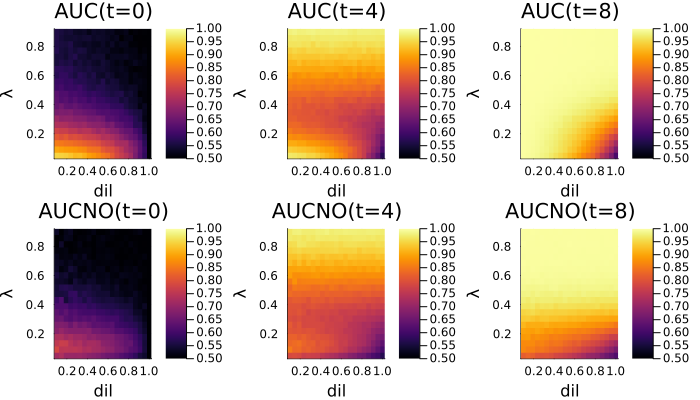

In [20]:
ymin =  0.05
ymax =  0.9
xmin =  0.1
xmax =  1.0
samp = 18
hAUCNO, hOv, hL1, hMSE, hiter, hfe = read_inference(samp, xmin, xmax, ymin, ymax,obs_inf=false)
samp = 19
hAUC, hOv, hL1, hMSE, hiter, hfe= read_inference(samp, xmin, xmax, ymin, ymax)
plot(hAUC[1],hAUC[5],hAUC[end],hAUCNO[1],hAUCNO[5],hAUCNO[end], size=(700,400),layout = (2,3),xlabel="dil",ylabel="λ",margin=Plots.mm)
#savefig("AUCvsAUCNO.pdf")

# Third Plot: free energies

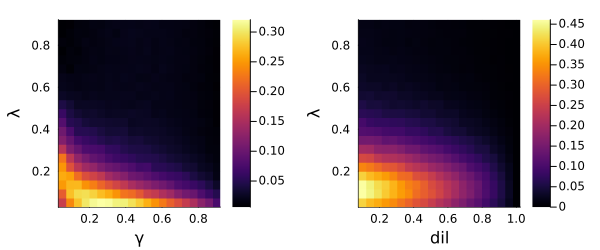

In [21]:
xmin =  0.1
xmax =  1.0
ymin = 0.05
ymax = 0.9
samp = 18
hAUCNO, hOv, hL1, hMSE, hiter, hfe = read_inference(samp, xmin, xmax, ymin, ymax,obs_inf=false)
pfedil = plot(hfe,xlabel="dil",ylabel="λ")
samp = 20
xmin = ymin 
xmax = ymax  
hAUC, hOv, hL1, hMSE, hiter, hfe = read_inference(samp, xmin, xmax, ymin, ymax)
pfegam = plot(hfe,xlabel="γ",ylabel="λ")
plot(pfegam,pfedil, size=(600,250),margin=3Plots.mm)
#savefig("free_energies.pdf")

# Fourth Plot: RSB

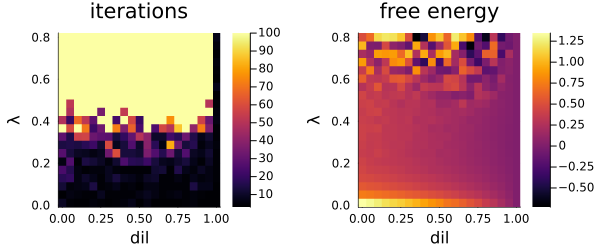

In [22]:
xmin =  0.0
xmax =  1.0
ymin = 0.01
ymax = 0.8
samp = 8  #quando lo hai prova 14
hAUCNO, hOv, hL1, hMSE, hiter, hfe = read_inference(samp, xmin, xmax, ymin, ymax,obs_inf=false)
pfe = plot(hfe,title="free energy")
plot(hiter,pfe, size=(600,250),margin=3Plots.mm,xlabel="dil",ylabel="λ")
#savefig("RSB.pdf")

# Fifth Plot: optimal vs learn

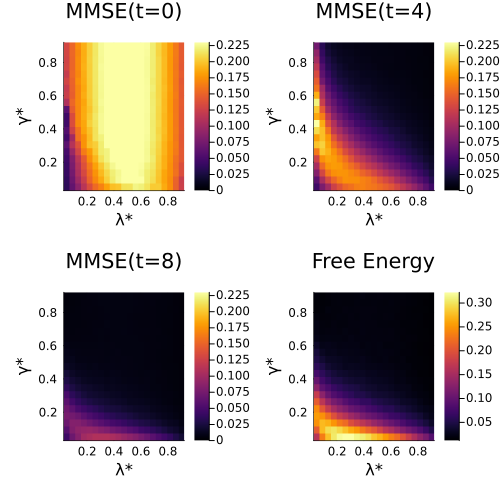

In [23]:
xmin =  0.05
xmax =  0.9
ymin = 0.05
ymax = 0.9
samp = 17

hAUC, hOv, hL1, hMSE, hiter, hfe = read_inference(samp, xmin, xmax, ymin, ymax)
pfe = plot(hfe,title="Free Energy")
plot(hMSE[1],hMSE[5],hMSE[end],pfe, size=(500,500),xlabel="λ*",ylabel="γ*",layout = (2,2),margin=2Plots.mm)
#savefig("gam_vs_lam_learn.pdf")

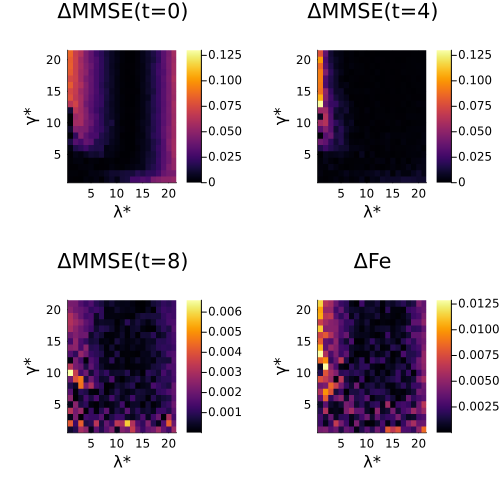

In [177]:
samp = 17
T =8
graph="er"
path = "./dil_lam_$(graph)_$(samp)/"
xmin =  0.05
xmax =  0.9
ymin = 0.05
ymax = 0.9
yRange = LinRange(ymin,ymax,21)
xRange = LinRange(xmin,xmax,21)
ninf = readdlm("$(path)ninf.txt")
Fe = readdlm("$(path)Fe.txt")
MSE = zeros(21,21,T+2)
for t = 1 : T + 1 
    MSE[:,:,t] .= readdlm("$(path)MSE$(t).txt") 
end
samp = 22
path = "./dil_lam_$(graph)_$(samp)/"
Feopt = readdlm("$(path)Fe.txt")
MSEopt = zeros(21,21,T+2)
for t = 1 : T + 1 
    MSEopt[:,:,t] .= readdlm("$(path)MSE$(t).txt") 
end
ΔMSE = abs.(MSE .- MSEopt)
ΔFe = abs.(Fe .- Feopt)
hMSE1 = heatmap(ΔMSE[:,:,1],title="ΔMMSE(t=0)",clims=(0,0.13))
hMSE4 = heatmap(ΔMSE[:,:,4],title="ΔMMSE(t=4)",clims=(0,0.13))
hMSE8 = heatmap(ΔMSE[:,:,8],title="ΔMMSE(t=8)")
hFe = heatmap(ΔFe,title="ΔFe")
plot(hMSE1,hMSE4,hMSE8,hFe,size=(500,500),xlabel="λ*",ylabel="γ*",layout = (2,2),margin=4Plots.mm)
#savefig("gam_vs_lam_learn.pdf")

# Sixth Plot: distance ($\gamma,\lambda$)

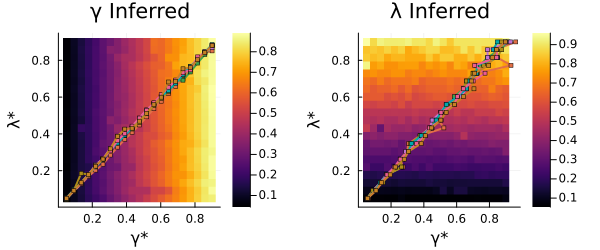

In [179]:
xmin =  0.05
xmax =  0.9
ymin = 0.05
ymax = 0.9
graph = "er"
samp = 24 
path = "./dil_lam_$(graph)_$(samp)/"
λinfer = readdlm("$(path)infλ.txt")
γinfer = readdlm("$(path)infγ.txt")
γRange = LinRange(xmin,xmax,21)
λRange = LinRange(ymin,ymax,21)
λtrue = λRange .* ones(size(λinfer))
γtrue = (γRange .* ones(size(γinfer)))'
hλ = heatmap(γRange,λRange,λinfer,xlabel="γ*",ylabel="λ*",title="λ Inferred")
#col=[:blue,:black,:red,:orange,:green,:purple,:grey,:white]
for st = 1:3:21
    hλ = plot!(λinfer[:,st],marker=:c,markersize=2,λRange,label=false)
end
hγ = heatmap(γRange,λRange,γinfer,xlabel="γ*",ylabel="λ*",title="γ Inferred")
for st = 1:3:21
    hγ = plot!(γRange,γinfer[st,:],label=false)
end

plot(hγ,hλ,size=(600,250),width=2,marker=:square,markersize=2,margin=3Plots.mm)

#hL2 = heatmap(x,y,sqrt.((λinfer .- λtrue) .^ 2 + (γinfer .- γtrue') .^ 2 ) ./ sqrt.(λtrue^2 .+ γtrue'^2) ,ylabel="λ",xlabel="γ")
#savefig("InferenceHyper.pdf")

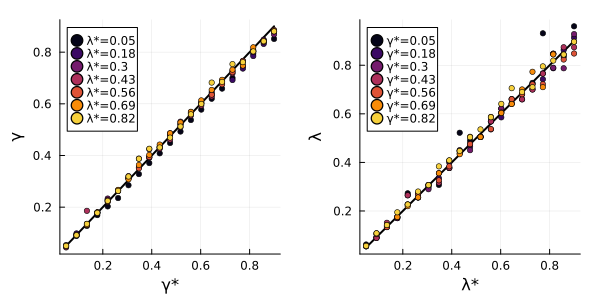

In [180]:
p1 = plot(λRange,λRange,label=false,color=:black,width=2)
#C(g::ColorGradient) = RGB[g[z] for z=LinRange(0,1,30)]
g = :inferno
for st = 1:3:21
    p1 = scatter!(λRange,λinfer[:,st],marker=cgrad(g)[st*12],markersize=3,colorscale=:blues,label="γ*=$(round(γRange[st],digits=2))",xlabel="λ*",ylabel="λ")
end
p2 = plot(γRange,γRange,label=false,color=:black,width=2)
for st = 1:3:21
    p2 = scatter!(γRange,γinfer[st,:],marker=cgrad(g)[st*12],markersize=3,color=:blues,label="λ*=$(round(λRange[st],digits=2))",xlabel="γ*",ylabel="γ")
end
plot(p2,p1,size=(600,300),margin=3Plots.mm)
#savefig("InferenceHyper.pdf")

# Seventh Plot: comparison sib VS ens

In [138]:
using Interpolations
function read_sib(graph,N,dil,t;T=8,d=3,samp=1)
    pathtest = "../test/AUCsibylN=$N/"
    name = Dict("er" => "poisson", "rr" => "regular")
    sib = readdlm("$(pathtest)$(graph)_AUC$(t)_dil_$(dil).txt")
    return sib
end
function read_ens(graph,N,dil,t;T=8,d=3,samp=1)
    ensemble = readdlm("dil_lam_$(graph)_$(samp)/AUC$(t).txt")
end
function n_infected(graph;T=8,d=3)
    ni = readdlm("./infected/ni_$(graph)_T=$(T)_d=$(d)_lam0.01_1.0.txt")
    itp = LinearInterpolation(LinRange(0.01,1,100),vec(ni));
    ni = [itp(t) for t in LinRange(0.01,0.4,41)];
end

n_infected (generic function with 1 method)

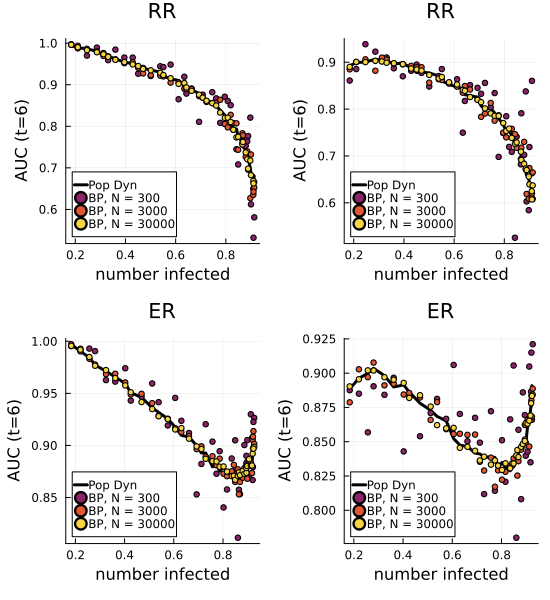

In [181]:
g = cgrad(:inferno)

graph,N,dil,t = "er", 300, 0.5, 6
sib300 = read_sib(graph,N,dil,t);
N = 3000
sib3000 = read_sib(graph,N,dil,t);
N = 30000
sib30000 = read_sib(graph,N,dil,t);
ens = read_ens(graph,N,dil,t);
ni = n_infected(graph)
p_er_05 = plot(ni,ens[:,2],ylabel="AUC (t=$t)",width=3,label="Pop Dyn",title="ER",color=:black,xlabel="number infected")
p_er_05 = scatter!(ni,sib300,color=g[100],markersize=3,label="BP, N = 300")
p_er_05 = scatter!(ni,sib3000,color=g[160],markersize=3,label="BP, N = 3000")
p_er_05 = scatter!(ni,sib30000,color=g[230],markersize=3,label="BP, N = 30000")

graph,N,dil,t = "er", 300, 0.0, 6
sib300 = read_sib(graph,N,dil,t);
N = 3000
sib3000 = read_sib(graph,N,dil,t);
N = 30000
sib30000 = read_sib(graph,N,dil,t);
ens = read_ens(graph,N,dil,t);
ni = n_infected(graph)
p_er_0 = plot(ni,ens[:,1],ylabel="AUC (t=$t)",width=3,label="Pop Dyn",title="ER",color=:black,xlabel="number infected")
p_er_0 = scatter!(ni,sib300,color=g[100],markersize=3,label="BP, N = 300")
p_er_0 = scatter!(ni,sib3000,color=g[160],markersize=3,label="BP, N = 3000")
p_er_0 = scatter!(ni,sib30000,color=g[230],markersize=3,label="BP, N = 30000")

graph,N,dil,t = "rr", 300, 0.5, 6
sib300 = read_sib(graph,N,dil,t);
N = 3000
sib3000 = read_sib(graph,N,dil,t);
N = 30000
sib30000 = read_sib(graph,N,dil,t);
ens = read_ens(graph,N,dil,t);
ni = n_infected(graph)
p_rr_05 = plot(ni,ens[:,2],ylabel="AUC (t=$t)",width=3,label="Pop Dyn",title="RR",color=:black,xlabel="number infected")
p_rr_05 = scatter!(ni,sib300,color=g[100],markersize=3,label="BP, N = 300")
p_rr_05 = scatter!(ni,sib3000,color=g[160],markersize=3,label="BP, N = 3000")
p_rr_05 = scatter!(ni,sib30000,color=g[230],markersize=3,label="BP, N = 30000")

graph,N,dil,t = "rr", 300, 0.0, 6
sib300 = read_sib(graph,N,dil,t);
N = 3000
sib3000 = read_sib(graph,N,dil,t);
N = 30000
sib30000 = read_sib(graph,N,dil,t);
ens = read_ens(graph,N,dil,t);
ni = n_infected(graph)
p_rr_0 = plot(ni,ens[:,1],ylabel="AUC (t=$t)",width=3,label="Pop Dyn",title="RR",color=:black,xlabel="number infected")
p_rr_0 = scatter!(ni,sib300,color=g[100],markersize=3,label="BP, N = 300")
p_rr_0 = scatter!(ni,sib3000,color=g[160],markersize=3,label="BP, N = 3000")
p_rr_0 = scatter!(ni,sib30000,color=g[230],markersize=3,label="BP, N = 30000")
plot(p_rr_0,p_rr_05,p_er_0,p_er_05,layout=(2,2),markersize=3,size=(550,600),margin=Plots.mm,legend=:bottomleft)
#savefig("sib_vs_ens.pdf")

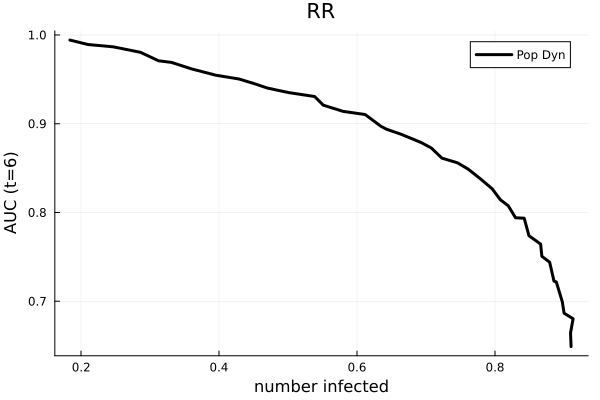

In [183]:
plot(ni,ens[:,2],ylabel="AUC (t=$t)",width=3,label="Pop Dyn",title="RR",color=:black,xlabel="number infected")